In [1]:
from unityagents import UnityEnvironment
import numpy as np
from maddpg import MADDPG
from collections import deque

In [2]:
file_name = "./Tennis_Windows_x86_64/Tennis.exe"

In [3]:
env = UnityEnvironment(file_name=file_name)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [6]:
mult_agents = MADDPG(state_size, action_size, num_agents)

In [7]:
def train(n_episodes: int = 2000):

    score_agent_1 = []
    score_agent_2 = []
    scores_window_1 = deque(maxlen=100)
    scores_window_2 = deque(maxlen=100)
    scores = []
    scores_window = deque(maxlen=100)

    warmup = 300


    for i_episode in range(1, n_episodes+warmup+1):

        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        mult_agents.reset(n_eps=n_episodes, curr_eps=i_episode)

        episode_rewards = np.zeros(num_agents)
        rewards_agent_1 = []
        rewards_agent_2 = []

        while True:
            if i_episode < warmup:
                actions = np.random.randn(num_agents, action_size)
                actions = np.clip(actions, -1, 1)
            else:
                actions = mult_agents.act(states)
                actions = np.clip(actions, -1, 1)

            env_info = env.step(actions)[brain_name]

            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            if i_episode < (warmup - 50):
                mult_agents.memory.add(states, actions, rewards, next_states, dones)
            else:
                mult_agents.step(states, actions, rewards, next_states, dones)

            states = next_states

            episode_rewards += rewards
            rewards_agent_1.append(rewards[0])
            rewards_agent_2.append(rewards[1])

            if np.any(dones):
                break
            

        episode_rewards = np.max(episode_rewards)
        episode_rewards_1 = np.sum(rewards_agent_1)
        episode_rewards_2 = np.sum(rewards_agent_2)

        scores.append(episode_rewards)
        scores_window.append(episode_rewards)
        scores_window_1.append(episode_rewards_1)
        scores_window_2.append(episode_rewards_2)
        score_agent_1.append(np.mean(episode_rewards_1))
        score_agent_2.append(np.mean(episode_rewards_2))

        current_noise = np.mean(mult_agents.get_current_sigma())

        print('\rEpisode {}\tEpisode Max Reward: {:.2f}\tAverage Score: {:.4f} \tCurrent Noise: {:.2f}'.format(i_episode, episode_rewards, np.mean(scores_window), current_noise), end="")

        if i_episode % 100 == 0:
            print('\rEpisode {}\tEpisode Max Reward: {:.2f}\tAverage Score: {:.4f} \tCurrent Noise: {:.2f}'.format(i_episode, episode_rewards, np.mean(scores_window), current_noise))

        if np.mean(scores_window) >= 0.7:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            break

    return scores, score_agent_1, score_agent_2

In [8]:
scores, agent_1_scores, agent_2_scores = train()

Episode 100	Episode Max Reward: 0.00	Average Score: 0.0191 	Current Noise: 0.81
Episode 200	Episode Max Reward: 0.10	Average Score: 0.0234 	Current Noise: 0.74
Episode 300	Episode Max Reward: 0.00	Average Score: 0.0230 	Current Noise: 0.67
Episode 400	Episode Max Reward: 0.00	Average Score: 0.0010 	Current Noise: 0.60
Episode 500	Episode Max Reward: 0.00	Average Score: 0.0742 	Current Noise: 0.55
Episode 600	Episode Max Reward: 0.10	Average Score: 0.1319 	Current Noise: 0.49
Episode 700	Episode Max Reward: 0.20	Average Score: 0.1972 	Current Noise: 0.45
Episode 800	Episode Max Reward: 1.69	Average Score: 0.5877 	Current Noise: 0.40
Episode 821	Episode Max Reward: 2.20	Average Score: 0.7124 	Current Noise: 0.40
Environment solved in 821 episodes!	Average Score: 0.7124


In [9]:
env.close()

In [11]:
import torch

In [13]:
# save all actor weights
for i in range(len(mult_agents.actors)):
    # save weights
    torch.save(mult_agents.actors[i].state_dict(), f'checkpoint_actor_{i}.pth')

In [14]:
# save all critic weights
for i in range(len(mult_agents.critics)):
    # save weights
    torch.save(mult_agents.critics[i].state_dict(), f'checkpoint_critic_{i}.pth')

In [22]:
running_mean = []

for i in range(len(scores)):
    if i < 100:
        running_mean.append(np.mean(scores[:i]))
    else:
        running_mean.append(np.mean(scores[i-100:i]))

Max Score length: 821
Max Score: 2.7000000402331352


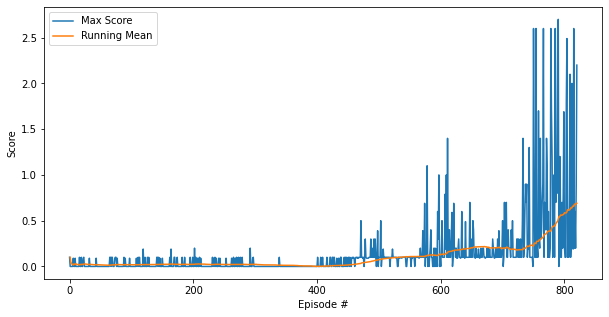

In [23]:
# plot the scores
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='Max Score')
plt.plot(np.arange(len(scores)), running_mean, label='Running Mean')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()